# Tutorial: applying strainFlye to the SheepGut dataset

This tutorial will walk you through some of the analyses that strainFlye can perform.

Here we will be using the same SheepGut dataset that is used in our paper, but feel free to follow along with another dataset.

The pipeline takes as input two primary types of data:

1. A __set of reads__ (in FASTA / FASTQ format) generated using PacBio HiFi sequencing.

2. An __assembly graph__ (in GFA 1 format) produced by running metaFlye (or another assembler) on these reads.

Please see the paper's "Data access" section for details about acquiring both of these types of data for the SheepGut dataset.

## Introduction

Here we take care of a few things before the tutorial starts.

### What commands are available through strainFlye?

In [1]:
!strainFlye

Usage: strainFlye [OPTIONS] COMMAND [ARGS]...

  Pipeline for the analysis of rare mutations in metagenomes.

  Please consult https://github.com/fedarko/strainFlye if you have any
  questions, comments, etc. about strainFlye. Thank you for using this tool!

Options:
  -h, --help  Show this message and exit.

Commands:
  align  Align reads to contigs, and filter the resulting alignment.
  call   [+] Call mutations naïvely, and compute diversity indices.
  fdr    [+] Estimate and fix FDRs for contigs' naïve mutation calls.
  spot   [+] Identify hotspots or coldspots in contigs.
  utils  [+] Various utility commands provided with strainFlye.


### Importing and configuring some utilities

You shouldn't need to actually do any programming to use strainFlye, but we'll be using Python to perform some plotting and other analyses throughout this tutorial—we'll import some useful packages here to reduce clutter in this notebook.

(If you prefer, you could of course use another language instead of Python!)

In [14]:
import pandas as pd
from math import ceil, floor
from matplotlib import pyplot

# Make our plots look pretty
# (this is the same style we use throughout most of the paper's figures)
pyplot.style.use("ggplot")

## 0. Convert the assembly graph to a FASTA file of contigs

**You can skip this step if:** you already have a FASTA file exactly matching the sequences of the segments in your GFA file.

Our assembly graph (the GFA file) contains the sequences of the contigs that we will use in many downstream analyses, but it will be helpful to have a FASTA file that just describes these contigs' sequences (independent of the assembly graph topology).

There are some [bash one-liners](https://www.biostars.org/p/169516/#169530) you can use to convert a GFA file to a FASTA file, but strainFlye also provides a utility command (`strainFlye utils gfa-to-fasta`) to do this for you. We'll use this here. (Our solution may be a bit slower than a bash one-liner, but it performs some useful sanity checking on the GFA file.)

In [46]:
!strainFlye utils gfa-to-fasta \
    --graph /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa \
    --output-fasta /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta

--------
strainFlye utils gfa-to-fasta @ 0.00 sec: Starting...
Input GFA file: /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa
Output FASTA file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta
--------
strainFlye utils gfa-to-fasta @ 14.97 sec: Done.
Output FASTA file contains 78,793 sequences.


## 1. Align reads to contigs; filter the resulting alignment

**You can skip this step if:** you already have a BAM file representing an alignment of reads to contigs, and this BAM file does not contain secondary alignments / partially-mapped reads / overlapping supplementary alignments (these all may cause problems in downstream analyses).

We'll need to align reads back to these contigs. The resulting alignment will be used in pretty much all downstream steps, so it's important to make sure that it is of good quality.

The `strainFlye align` command produces a BAM file corresponding to such an alignment. 

Note that this command, in particular, may take a while to run. Sequence alignment is computationally expensive! On our cluster, `strainFlye align` ran on the full SheepGut dataset in 62,941.21 seconds (aka about 17.5 hours).

In [26]:
!strainFlye align

Usage: strainFlye align [OPTIONS] READS...

  Align reads to contigs, and filter the resulting alignment.

  Files of reads should be in the FASTA or FASTQ formats; GZIP'd files are
  allowed.

  This command involves multiple steps, including:

    1) Align reads to contigs (using minimap2) to generate a SAM file
    2) Convert this SAM file to a sorted and indexed BAM file
    3) Filter overlapping supplementary alignments within this BAM file
    4) Filter partially-mapped reads within this BAM file

  Note that we only sort the alignment file once, although we do re-index it
  after the two filtering steps. This decision is motivated by
  https://www.biostars.org/p/131333/#131335.

Options:
  -c, --contigs PATH          FASTA file of contigs to which reads will be
                              aligned.  [required]
  -g, --graph PATH            GFA 1-formatted file describing an assembly
                              graph of the contigs. This is used in the
                        

In [4]:
!strainFlye align \
    # We can use the FASTA file we just generated above.
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --graph /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/alignment \
    # Reads file(s) are specified here, after all of the other parameters:
    /Poppy/mkolmogo/sheep_meta/data/sheep_poop_CCS_dedup.fastq.gz \
    /Poppy/mkolmogo/sheep_meta/data/ccs_sequel_II/*.fasta.qz

This generates a BAM file (`final.bam`) and BAM index file (`final.bam.bai`) in the specified output directory.

We can use this BAM file for many analyses downstream—the first of these will be mutation calling.

## 2. Perform naïve mutation calling; estimate and fix FDRs

**You can skip this step if:** you already have a BCF file indicating single-nucleotide variant calls in these contigs.

The analyses downstream of this step take as input a set of identified single-nucleotide mutations (or, if you prefer to use different terminology, "called variants", "called SNVs", ...) in which we have some confidence. First, we will naïvely call mutations using a simple threshold-based method (referred to as "NaiveFreq" in the paper). We'll then estimate the false-discovery rates of the mutations called for each contig using the target-decoy approach, and then adjust the called mutations to fix the false-discovery rates of these mutation calls below a specified threshold.

### 2.1. $p$-mutations and $r$-mutations?

strainFlye supports calling two basic types of mutations: $p$-mutations and $r$-mutations. The docs explain the difference between these two types best:

In [28]:
!strainFlye call

Usage: strainFlye call [OPTIONS] COMMAND [ARGS]...

  [+] Call mutations in contigs naïvely & compute diversity indices.

  Consider a position "pos" in a contig. A given read with a (mis)match
  operation at "pos" must have one of four nucleotides (A, C, G, T) aligned to
  pos. We represent these nucleotides' counts at pos as follows:

      N1 = # reads of the most-common aligned nucleotide at pos,
      N2 = # reads of the second-most-common aligned nucleotide at pos,
      N3 = # reads of the third-most-common aligned nucleotide at pos,
      N4 = # reads of the fourth-most-common aligned nucleotide at pos.

  (We break ties arbitrarily.)

  strainFlye supports two types of naïve mutation calling based on these
  counts: p-mutations and r-mutations. These are described below.

  p-mutations (naïve percentage-based mutation calling)
  -----------------------------------------------------

  This takes as input some percentage p in the range (0%, 50%]. Define
  freq(pos) = N2 / (N1 +

### 2.2. Understanding these (sub)commands

First off, note that `strainFlye call` doesn't do anything besides show help info if you run it by itself. This is because, unlike `strainFlye align`, `strainFlye call` has two subcommands: `p-mutation` and `r-mutation`. Which of these you use will depend on how you want to naïvely call mutations. You can invoke one of these subcommands by listing out the full chain of commands: for example, `strainFlye call p-mutation`.

#### 2.2.1. Input and output

Both of these subcommands, `strainFlye call p-mutation` and `strainFlye call r-mutation`, take as input a *minimum* version of their corresponding threshold (either `--min-p` or `--min-r`).

These commands each output:

1. A __BCF (binary [variant call format](https://samtools.github.io/hts-specs/VCFv4.3.pdf)) file__ describing all mutations called naïvely across the contigs, based on the minimum $p$ or $r$ threshold set (`--min-p` or `--min-r`).

2. A __TSV ([tab separated values](https://en.wikipedia.org/wiki/Tab-separated_values)) file__ describing the contigs' computed diversity indices, for various values of $p$ or $r$ (controllable using the `--div-index-p-list` or `--div-index-r-list` parameters). Long story short, diversity indices indicate how many of a contig's (sufficiently-covered) positions have called mutations: in general, higher diversity indices mean more mutations.

#### 2.2.2. Interpreting the output

The default minimum value of $p$ (or $r$) used in these commands is fairly low. As you might expect, using such a low threshold for calling a position as a mutation will yield many false positives: we will definitely identify some real mutations, but also many "false" mutations that occur as the result of sequencing errors, alignment errors, etc. Viewed another way, the __false discovery rate (FDR)__ (defined as the ratio of false positives to total true + false positives) of our mutation calls will probably be unacceptably high.

After we run this command, we'll use strainFlye's FDR estimation and fixing functionality to try to address this problem. This will involve adjusting the "minimum" value of $p$ or $r$ used for each contig to reduce the FDR as needed.

### 2.3. Naïvely call $p$-mutations ($p = 0.15\%$) and compute diversity indices for various values of $p$

Now that we know what we're doing, we're ready to call mutations and compute diversity indices! We'll do $p$-mutation calling at a minimum $p$ of $0.15\%$, which matches what we used for Figure 2 in the paper. The default diversity index values of $p$ (ranging from $0.5\%$ to $50\%$) should be good for us.

Note that this command will take a while—because we're running it on all of the contigs in the SheepGut dataset, and we need to check each position in the alignment for each of these contigs. If you'd like, you can only perform mutation calling on some of these contigs by passing in a FASTA file that describes only a subset of contigs included in the BAM file. (However, we'll consider the full dataset here, at least for the time being.)



In [29]:
!strainFlye call p-mutation

Usage: strainFlye call p-mutation [OPTIONS]

  Call p-mutations and compute diversity indices.

  The primary parameter for this command is the lower bound of p, defined by
  --min-p. The BCF output will include "mutations" for all positions that pass
  this (likely very low) threshold, but this BCF should be adjusted using the
  utilities contained in the "strainFlye fdr" module.

Options:
  -c, --contigs PATH              FASTA file of contigs in which to naïvely
                                  call mutations. All contigs in this FASTA
                                  file should also be contained in the BAM
                                  file; however, if some contigs in the BAM
                                  file are not included in this FASTA file, we
                                  won't perform any calling on these absent
                                  contigs.  [required]
  -b, --bam PATH                  Sorted and indexed BAM file representing an
               

In [ ]:
!strainFlye call p-mutation \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --bam /Poppy/mfedarko/sftests/tutorial-output/alignment/final.bam \
    --min-p 15 \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/p0.15-calling

### 2.4. Analyzing diversity indices: the search for a decoy contig

We now have both our initial mutation calls (which, as we've discussed, probably have a high FDR) and information about our contigs' diversity indices. We will use the __target-decoy approach__ to attempt to estimate and thus control the FDR of our mutation calls. This is done by the `strainFlye fdr estimate` and `strainFlye fdr fix` commands.

As discussed in our paper, we can select—out of one of our $C$ contigs—a __decoy contig__ (a.k.a. a decoy genome), and compute a mutation rate for it ($\text{rate}_{\text{decoy}}$). For each of the other $C - 1$ __target contigs__, we can estimate the FDR of identified mutations in this contig as $\dfrac{\text{rate}_{\text{decoy}}}{\text{rate}_{\text{target}}}$.

#### 2.4.1. How do we select a decoy contig?

The first hurdle we'll need to surmount is selecting a decoy contig. What would make a good decoy? We can define some rules—

1. A low number of "real" mutations
2. High coverage
3. High length

The first two of these criteria match up pretty well with the diversity indices we computed earlier, which—unlike the naïve mutations described in the BCF file—take coverage information into account.

If we provide our diversity index TSV file from `strainFlye call` to `strainFlye fdr estimate`, it can automatically select a decoy contig for us. We can also specify the decoy contig ourselves, if preferred.

For the sake of demonstration, we'll demonstrate how to use Python to analyze and plot the diversity indices we've already generated (as a way of looking for promising decoy contigs).

#### 2.4.2. Analyzing diversity indices

First, we'll load the TSV file of diversity index information into a [pandas](https://pandas.pydata.org/) DataFrame.

In [4]:
div_idx = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/p-div-indices.tsv", sep="\t", index_col=0)
div_idx.head()

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_1,460.398484,39565,NaN,NaN,0.00889,0.007611,0.004804,0.002604,0.0
edge_2,63.644295,745,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0
edge_3,258.569823,38161,NaN,NaN,NaN,0.008092,0.006793,0.004086,0.0
edge_4,187.858268,1397,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
edge_5,3.356588,32079,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(f"The dimensions of the DataFrame of diversity indices are {div_idx.shape[0]:,} x {div_idx.shape[1]:,}.")

The dimensions of the DataFrame of diversity indices are 78,793 x 9.


This DataFrame has dimensions (aka "shape") $C$x($D$ + 2), where $C$ is the number of contigs we performed mutation calling on (for SheepGut, 78,793) and $D$ is the number of values of $p$ included in `--div-index-p-list` (by default, seven).

There are two extra columns included at the start of the DataFrame describing contigs' average coverages (only considering (mis)match operations) and lengths. Let's sort this DataFrame (in descending order, i.e. high to low) by average coverages.

In [6]:
div_idx.sort_values(["AverageCoverage"], ascending=False).head()

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_4390,19640.323050,16208,0.002468,0.002468,0.002406,0.002406,0.001111,0.001049,0.0
edge_16794,15689.671505,38786,0.000155,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
edge_8210,6526.632450,604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
edge_4165,6176.073015,163308,0.000056,0.000006,0.000000,0.000000,0.000000,0.000000,0.0
edge_4083,6132.755501,167755,0.000072,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


We see a fair amount of high-coverage but relatively short contigs. Let's try filtering to contigs that are at least 1 Mbp (i.e. $1 \times 10^6$ = 1,000,000 bp), and then sorting by average coverage.

In [7]:
div_idx_just_long = div_idx[div_idx["Length"] >= 1e6]
print(f"There are {div_idx_just_long.shape[0]:,} contigs with length \u2265 1 Mbp.")
div_idx_just_long_cov_sorted = div_idx_just_long.sort_values(["AverageCoverage"], ascending=False)
div_idx_just_long_cov_sorted.head()

There are 468 contigs with length ≥ 1 Mbp.


,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_6104,4158.572469,1289244,0.000221,0.000064,0.000040,0.000027,0.000027,0.000000e+00,0.0
edge_2358,2993.461914,2806161,0.000581,0.000135,0.000040,0.000005,0.000002,1.069076e-06,0.0
edge_1371,2215.936973,1634973,0.001173,0.000991,0.000909,0.000651,0.000081,5.749330e-05,0.0
edge_23917,1987.798829,1020213,0.009018,0.003313,0.000775,0.000467,0.000306,0.000000e+00,0.0
edge_1671,1415.072755,2153394,0.011340,0.010501,0.008338,0.003400,0.000240,4.679987e-07,0.0


Now we're getting somewhere. These are all high-coverage, high-length contigs. (For reference, `edge_6104`, `edge_1671`, and `edge_2358` correspond to CAMP, BACT1, and BACT2 from the paper.)

Let's do another sorting operation: this time, by the diversity index column corresponding to the lowest value of $p$ included (50, aka $p = (50 / 100) = 0.5\%$). We'll sort in ascending order this time, since we're interested in contigs with relatively low diversity indices.

In [8]:
div_idx_final = div_idx_just_long_cov_sorted.sort_values("DivIdx(p=50,minSuffCov=1000.0)")
div_idx_final.head(10)

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_6104,4158.572469,1289244,0.000221,0.000064,0.000040,0.000027,0.000027,0.000000e+00,0.000000e+00
edge_16244,1318.792597,2448520,0.000297,0.000104,0.000083,0.000078,0.000063,1.266098e-05,0.000000e+00
edge_2358,2993.461914,2806161,0.000581,0.000135,0.000040,0.000005,0.000002,1.069076e-06,0.000000e+00
edge_1371,2215.936973,1634973,0.001173,0.000991,0.000909,0.000651,0.000081,5.749330e-05,0.000000e+00
edge_4773,1176.249727,1371455,0.001268,0.000947,0.000865,0.000841,0.000556,0.000000e+00,0.000000e+00
edge_11863,1057.411793,2597011,0.001933,0.000818,0.000670,0.000345,0.000208,1.136314e-04,3.898408e-07
edge_23917,1987.798829,1020213,0.009018,0.003313,0.000775,0.000467,0.000306,0.000000e+00,0.000000e+00
edge_1671,1415.072755,2153394,0.011340,0.010501,0.008338,0.003400,0.000240,4.679987e-07,0.000000e+00
edge_7349,1325.510426,1175877,0.012973,0.010487,0.008060,0.003285,0.001409,3.500673e-04,1.713526e-06


Nice! This confirms our finding in the paper that `edge_6104` (CAMP) has relatively high coverage and length, and a relatively low diversity index. `edge_16244` could also be useful as a decoy contig, but CAMP has a higher coverage and lower diversity indices (for all diversity index columns we analyzed). CAMP is shorter than `edge_16244`, but both contigs have lengths ≥ 1 Mbp—so it's not a big deal.

We've just shown one way of analyzing the diversity indices, by just inspecting a DataFrame of them—we could also plot diversity indices graphically, if desired. For completeness' sake, the following section shows an example of such a plot, but feel free to skip it.

#### 2.4.3. Plotting a histogram of diversity indices (using $p = 0.5\%$)

Note that this plot implicitly ignores contigs with `NA` diversity indices, at least for the $p = 0.5\%$ diversity index column. A contig could have a diversity index of `NA` (or `NaN`, as pandas displays it) if the diversity index isn't defined for this contig; this happens if a contig doesn't have enough sufficiently-covered positions for the $p$ or $r$ threshold used to compute this diversity index.

The histogram we'll plot here matches the second-from-the-bottom histogram shown in the diversity index figure in the paper (at least as of writing). Like in that figure, we'll highlight `edge_6104` to show how its diversity index compares to other contigs'.

(For comparison, the code that generated Figure 4 in the paper is located [here](https://nbviewer.org/github/fedarko/sheepgut/blob/main/notebooks/DiversityIndices.ipynb), although the data was produced using the paper's _ad hoc_ analysis code and not using strainFlye.)

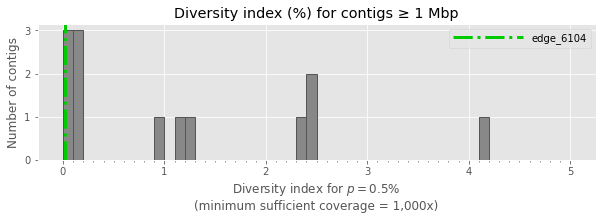

In [25]:
fig, ax = pyplot.subplots()

# You can change this to use a different column than p = 0.5%, if desired (although you should also
# update the x-axis label in this case).
DI_COL = "DivIdx(p=50,minSuffCov=1000.0)"

# Convert diversity indices to percentages
di_pcts = div_idx_final[DI_COL] * 100

# Create a histogram bin for every 0.1%. Also add nice little ticks demarcating these bins.
max_di_pct = ceil(max(di_pcts))
bins = [x / 10 for x in range((max_di_pct * 10) + 1)]

# Highlight edge_6104 (assuming it's defined for this diversity index, which it should be)
if not pd.isna(di_pcts["edge_6104"]):
    ax.axvline(di_pcts["edge_6104"], color="#00cc00", lw=3, linestyle="-.", label="edge_6104")

ax.hist(di_pcts, bins=bins, color="#888888", lw=1, edgecolor="#555555")
ax.set_xticks(bins, minor=True)

ax.set_title("Diversity index (%) for contigs \u2265 1 Mbp")
ax.set_xlabel("Diversity index for $p = 0.5\%$\n(minimum sufficient coverage = 1,000x)")
ax.set_ylabel("Number of contigs")
ax.legend(handlelength=7)
fig.set_size_inches(10, 2.5)

Not a lot of contigs have defined diversity indices at $p = 0.5\%$; however, of those that do have defined diversity indices, there's a fairly wide range (from around 0% to around 4.1%).

### 2.5. Estimating FDRs using the target-decoy approach

We've seen that `edge_6104` is probably a good decoy contig, so we could if desired just pass it to `strainFlye fdr estimate` using that command's `-dc` or `--decoy-contig` option. However, to illustrate another option, we'll instead pass our diversity index information to `strainFlye fdr estimate` and let it do the job of selecting a decoy contig. (Spoiler alert: it'll select `edge_6104` anyway.)

In [30]:
!strainFlye fdr

Usage: strainFlye fdr [OPTIONS] COMMAND [ARGS]...

  [+] Estimate and fix FDRs for contigs' naïve mutation calls.

Options:
  -h, --help  Show this message and exit.

Commands:
  estimate  Estimate the FDRs of contigs' naïve mutation calls.
  fix       Fix contigs' naïve mutation calls' FDRs to an upper limit.


In [31]:
!strainFlye fdr estimate

Usage: strainFlye fdr estimate [OPTIONS]

  Estimate the FDRs of contigs' naïve mutation calls.

  We do this using the target-decoy approach (TDA). Given a set of C contigs,
  we select a "decoy contig" with relatively few called mutations. We then
  compute a mutation rate for this decoy contig, and use this mutation rate
  (along with the mutation rates of the other C - 1 "target" contigs) to
  estimate the FDRs of all of these target contigs' mutation calls.

  We can produce multiple FDR estimates for a single target contig's calls by
  varying the p or r threshold used (from the --min-p or --min-r threshold
  used to generate the input BCF file, up to the --high-p or --high-r
  threshold given here). Using this information (and information about the
  numbers of mutations called per megabase), we can plot an FDR curve for a
  given target contig's mutation calls.

Options:
  -c, --contigs PATH              FASTA file of contigs.  [required]
  -b, --bcf PATH                  Index

In [12]:
!strainFlye fdr estimate \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf \
    --diversity-indices /Poppy/mfedarko/sftests/tutorial-output/p-div-indices.tsv \
    --decoy-context Full \
    --output-fdr-info /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv \
    --output-num-info /Poppy/mfedarko/sftests/tutorial-output/p-num-info.tsv

--------
strainFlye fdr estimate @ 0.00 sec: Starting...
Input contig file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf
Input diversity indices file: /Poppy/mfedarko/sftests/tutorial-output/p-div-indices.tsv
Input manually-set decoy contig: None
Input decoy contig context-dependent mutation type: Full
Input high p threshold (only used if the BCF describes p-mutations): 500
Input high r threshold (only used if the BCF describes r-mutations): 100
Input min length of a potential decoy contig (only used if diversity indices are specified): 1000000
Input min average coverage of a potential decoy contig (only used if diversity indices are specified): 500.0
Output FDR estimate file: /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv
Output number of mutations per megabase file: /Poppy/mfedarko/sftests/tutorial-output/p-num-info.tsv
--------
strainFlye fdr estimate @ 0.00 sec: Loading and checking contig i

### 2.6. Plotting FDR curves

To demonstrate how to plot this information, let's plot FDR curves for 25 relatively-high-mutation-rate contigs (considering 25 contigs that are at least 1 Mbp long and have the relatively highest diversity indices at $p = 2\%$).

(We use the $p = 2\%$ diversity indices here arbitrarily; the main reason is that there aren't 25 sufficiently-covered target contigs for any of the lower values of $p$ that we computed diversity indices.)

In [22]:
fdr_ests = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv", sep="\t", index_col=0)
numpermbs = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/p-num-info.tsv", sep="\t", index_col=0)

In [23]:
div_idx_high_to_low = div_idx_just_long_cov_sorted.sort_values("DivIdx(p=200,minSuffCov=250.0)", ascending=False)
div_idx_high_to_low.head(25)

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_3030,1035.740707,1915304,0.041088,0.033952,0.031322,0.025060,0.017557,4.156003e-04,1.566332e-06
edge_8569,270.174269,2087330,NaN,NaN,0.022879,0.010612,0.004040,4.720476e-04,2.142210e-05
edge_7356,742.905564,1602179,0.024833,0.021453,0.017328,0.006580,0.001584,2.563919e-04,0.000000e+00
edge_1526,518.044165,2338731,NaN,0.019049,0.016268,0.012120,0.007084,5.687054e-04,4.320621e-07
edge_1350,292.412389,2038177,NaN,NaN,0.016155,0.005192,0.000967,5.359177e-04,2.957263e-06
edge_7354,1119.104000,1036318,0.023789,0.018875,0.015372,0.009458,0.005996,1.543928e-05,0.000000e+00
edge_1717,603.009889,2679593,NaN,0.017519,0.012952,0.008134,0.002695,1.836866e-04,0.000000e+00
edge_3402,877.282137,3713351,0.024924,0.018800,0.012130,0.002100,0.000195,1.008768e-04,2.706565e-07
edge_2406,284.263638,1769728,NaN,NaN,0.010964,0.006916,0.003068,3.085644e-04,0.000000e+00


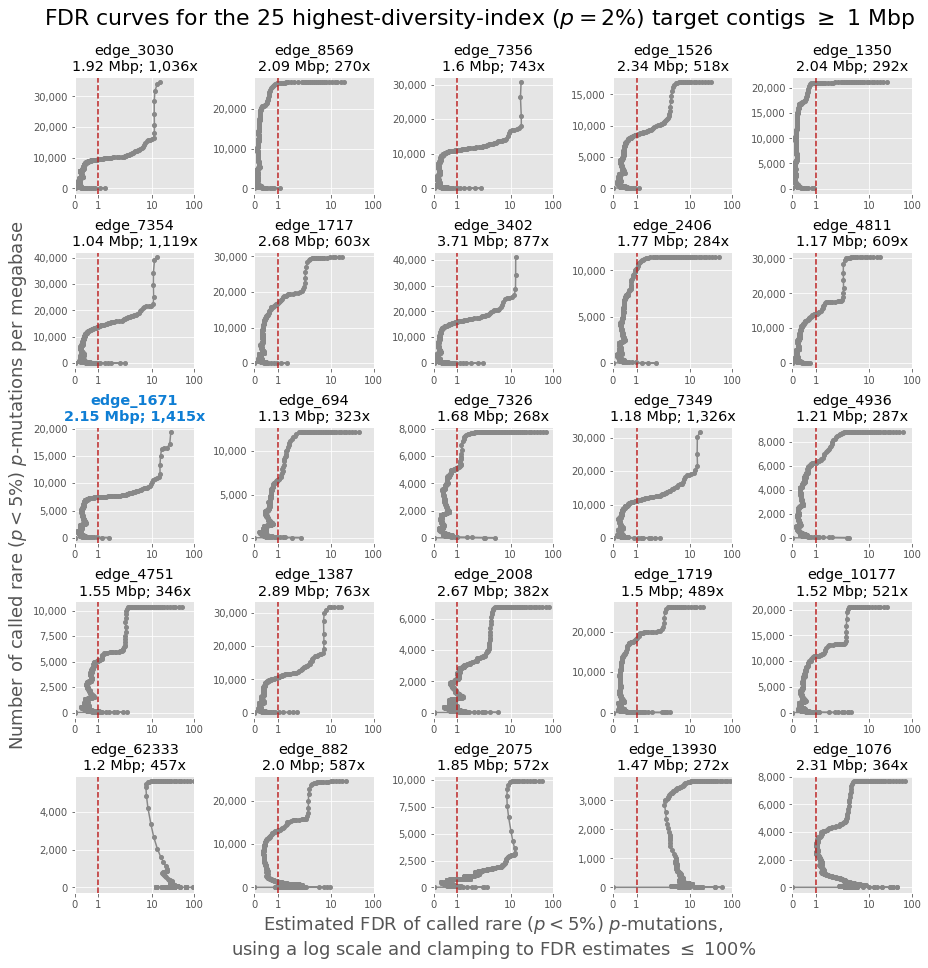

In [24]:
fig, axes = pyplot.subplots(5, 5, gridspec_kw={"hspace": 0.5, "wspace": 0.5})

contigs_to_plot = list(div_idx_high_to_low.index[:25])

# Ignore the decoy genome here: we don't have FDR estimates for it
if "edge_6104" in contigs_to_plot:
    contigs_to_plot.remove("edge_6104")
    contigs_to_plot.append(div_idx_high_to_low.index[25])

for ci, contig in enumerate(contigs_to_plot):
    # We'll organize the grid of plots starting from the top-left and moving right:
    # 0 1 2 3 4
    # 5 6 7 8 9
    # ... and so on, until we get to ci = 24.
    col = ci % 5
    row = floor(ci / 5)
    
    # Figure out exactly which points to plot -- ignore cases where no mutations were called
    # for this contig, since this results in a target mutation rate of 0 (resulting in an
    # undefined FDR). I'm pretty sure matplotlib will automatially account for this case without
    # us needing to do this, but I'm paranoid.
    x = []
    y = []
    xvals = fdr_ests.loc[contig]
    yvals = numpermbs.loc[contig]
    for f, n in zip(xvals, yvals):
        if not pd.isna(f):
            x.append(f)
            y.append(n)
    
    length_info = f"{round(div_idx_high_to_low['Length'][contig] / 1e6, 2):,} Mbp"
    cov_info = f"{round(div_idx_high_to_low['AverageCoverage'][contig]):,}x"
    title = f"{contig}\n{length_info}; {cov_info}"
    
    # Highlight the "selected" contigs (BACT1, BACT2) in blue
    tparams = {}
    if contig == "edge_1671" or contig == "edge_2358":
        tparams = {"fontweight": "semibold", "color": "#0f7ed4"}
    axes[row, col].set_title(title, **tparams)

    axes[row, col].plot(x, y, marker="o", color="#888", markersize=4)
    axes[row, col].axvline(x=1, linestyle="--", color="#b22")
    axes[row, col].set_xscale("symlog")
    axes[row, col].xaxis.set_major_formatter("{x:,.0f}")
    axes[row, col].yaxis.set_major_formatter("{x:,.0f}")
    axes[row, col].set_xlim(0, 100)

axes[2, 0].set_ylabel("Number of called rare ($p < 5\%$) $p$-mutations per megabase", fontsize=18)
axes[4, 2].set_xlabel(
    "Estimated FDR of called rare ($p < 5\%$) $p$-mutations,\nusing a log scale and clamping to FDR estimates $\leq$ 100%",
    fontsize=18
)
fig.suptitle(
    "FDR curves for the 25 highest-diversity-index ($p = 2\%$) target contigs $\geq$ 1 Mbp",
    fontsize=22,
    y=0.945
)
fig.set_size_inches(15, 15)

### 2.7. Fixing mutation calls' FDRs to an upper limit of $1\%$

In [32]:
!strainFlye fdr fix

Usage: strainFlye fdr fix [OPTIONS]

  Fix contigs' naïve mutation calls' FDRs to an upper limit.

  This takes as input the estimated FDRs from "strainFlye fdr estimate" to
  guide us on how to fix the FDR for each contig. Note that mutations that
  passed the "high" p or r threshold specified for "strainFlye fdr estimate",
  and thus were not used for FDR estimation, will all be included in the
  output BCF file from this command; these mutations are considered
  "indisputable."

  We include indisputable mutations from the decoy contig and from all target
  contigs our output BCF file. We will only consider including non-
  indisputable mutations from the target contigs: the decision of which non-
  indisputable mutations will be included is based on the lowest p or r
  parameter for a target contig that yields an estimated FDR ≤ the fixed FDR
  given here.

Options:
  -b, --bcf PATH            Indexed BCF file describing naïvely called p- or
                            r-mutations.

In [23]:
!strainFlye fdr fix \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf \
    --fdr-info /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv \
    --fdr 1 \
    --output-bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15-fdr1pct.bcf

--------
strainFlye fdr fix @ 0.00 sec: Starting...
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf
Input FDR estimate file: /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv
Input FDR to fix mutation calls at: 1.0
Output BCF file with mutation calls at the fixed FDR: /Poppy/mfedarko/sftests/tutorial-output/p0.15-fdr1pct.bcf
--------
strainFlye fdr fix @ 0.00 sec: Loading and checking BCF and TSV files...
strainFlye fdr fix @ 2.81 sec: Looks good so far; decoy contig seems to be edge_6104.
strainFlye fdr fix @ 2.81 sec: Looks like the cutoff for "indisputable" mutations was p = 500.
strainFlye fdr fix @ 2.81 sec: All mutations passing this cutoff will be included in the output BCF file.
--------
strainFlye fdr fix @ 2.81 sec: Based on the FDR information, finding optimal values of p for each contig...
strainFlye fdr fix @ 6.08 sec: Done.
strainFlye fdr fix @ 6.08 sec: For 4,168 / 78,792 contigs, there exist values of p (at least, considering the range from p = 15

It took a few steps, but we have now generated a file (`p0.15-fdr1pct.bcf`) of $p$-mutation calls at a fixed (estimated) FDR of 1%.

Although our methodology has a few limitations (e.g. we don't support calling multi-allelic mutations yet), this BCF file could be used downstream for a variety of analyses. In the next sections of the tutorial we'll demonstrate the additional analyses supported by strainFlye, most of which make use of these mutation calls in some way.

## 3. Identifying hotspots and coldspots

Now we can get to the fun part!

Given our called mutations, we may be interested in analyzing their locations in the contigs. Are there any particular regions, for example, where there are surprisingly many mutations? Are there any long regions where there are, surprisingly, no mutations?

We've kept strainFlye's functionality for identifying these types of regions fairly minimal at the moment. Here we'll demonstrate identifying basic hotspots and coldspots using `strainFlye spot`'s commands.

In [36]:
!strainFlye spot

Usage: strainFlye spot [OPTIONS] COMMAND [ARGS]...

  [+] Identify hotspots or coldspots in contigs.

  There exist other methods for identifying hotspots or coldspots; these
  methods are intended mostly as a quick proof-of-concept for replicating the
  results shown in our paper, and are not extremely robust quite yet.

Options:
  -h, --help  Show this message and exit.

Commands:
  hot-features  Identify hotspot features (for example, genes).
  cold-gaps     Identify coldspot "gaps" without any mutations.


### 3.1. Identifying hotspot features

In [42]:
!strainFlye spot hot-features

Usage: strainFlye spot hot-features [OPTIONS]

  Identify hotspot features (for example, genes).

  By "feature", we refer to a region within a contig, as described in the file
  given for --features. For prokaryotic genomes, "features" will usually refer
  to genes, but you could imagine other things being described here (exons,
  intergenic regions of interest, etc).

  You can configure whether or not we classify a feature as a hotspot by
  adjusting the --min-num-mutations and --min-perc-mutations parameters; at
  least one of these parameters must be specified. If both parameters are
  specified, then both checks (number of mutations in a feature vs. percentage
  of mutations in a feature) will need to pass in order for us to label a
  feature as a hotspot.

Options:
  -b, --bcf PATH                  Indexed BCF file describing single-
                                  nucleotide mutations in a set of contigs.
                                  [required]
  -f, --features PATH     

#### 3.1.1. A note about "features"

Although we should be familiar with the FASTA and BCF input files by this point, the `-f` / `--features` input (a GFF3 file) may be surprising. strainFlye leaves the task of creating this file up to the user.

Predicted genes' coordinates are probably the most obvious type of "feature" for which we could look for hotspots. If you don't have gene predictions for your contigs yet, [Prodigal](https://github.com/hyattpd/Prodigal) is good (and should have been installed along with strainFlye, since other parts of strainFlye make use of it internally).

It's important to note that Prodigal does not predict eukaryotic genes (i.e. genes that are split up into introns and exons). These genes will thus not be a perfect representation of all protein-coding genes in all contigs in the dataset, since we know that this sample does contain at least some eukaryotic genomes. However, if you use another tool for predicting eukaryotic genes, then these should also be usable as "features" for this command.

The command below will predict protein-coding genes across all contigs, and ran in 570 minutes and 21.2 seconds (about 9.5 hours) on our cluster:

In [ ]:
# See https://github.com/hyattpd/Prodigal/wiki/cheat-sheet for details about these options.
#
# Note that, for the paper, I ran Prodigal in "normal" mode on certain contigs individually
# (https://github.com/fedarko/sheepgut/blob/main/inspect-seqs/prodigal.py), but here we just
# run Prodigal in "anonymous" mode on all contigs at once. The results should be fairly similar.
!prodigal \
    -i /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    -f gff \
    -c \
    -p meta \
    -o /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff

#### 3.1.2. Finally running the command to identify hotspot features

Now that we have our gene predictions, let's move see if any have a lot of mutations. (Based on our findings in the paper, we know that these sorts of hotspots do exist in this dataset.)

We will call a feature a "hotspot" if this feature meets both of the following criteria:

1. It contains at least 5 mutations.
2. At least 2% of its positions have mutations.

In [43]:
!strainFlye spot hot-features \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15-fdr1pct.bcf \
    --features /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff \
    --min-num-mutations 5 \
    --min-perc-mutations 2 \
    --output-hotspot-features /Poppy/mfedarko/sftests/tutorial-output/hotspot-features-n5p2.tsv

--------
strainFlye spot hot-features @ 0.00 sec: Starting...
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p0.15-fdr1pct.bcf
Input feature file: /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff
Input minimum number of mutations needed to call a feature a hotspot: 5
Input minimum % of mutations needed to call a feature a hotspot: 2.0
Output file describing hotspot features: /Poppy/mfedarko/sftests/tutorial-output/hotspot-features-n5p2.tsv
--------
strainFlye spot hot-features @ 0.00 sec: Done.
